# Stokes streamfunction formulation

boundary value problem on $\textbf{x}\in\Omega$ 

$$\nabla\cdot\textbf{u} = 0$$
$$\textbf{0}=-\nabla p + \mu\nabla^2\textbf{u} + \textbf{f}$$

streamfunction formulation with constant $\mu$

$$\textbf{u}=\nabla\times\boldsymbol{\psi} \iff \nabla\cdot\textbf{u}=0$$

$$\implies\textbf{0}=\mu\nabla^2(\nabla\times\boldsymbol{\psi}) + \nabla\times\textbf{f}$$

$d=2$ Cartesian formulation

$$\textbf{u}=\nabla\times\psi\textbf{e}_z=-\frac{\partial\psi}{\partial y}\textbf{e}_x + \frac{\partial\psi}{\partial x}\textbf{e}_y$$

$$\textbf{f}=f_x\textbf{e}_x + f_y\textbf{e}_y$$

$$\implies\mu\nabla^2(\nabla^2\psi) = \frac{\partial f_y}{\partial x}- \frac{\partial f_x}{\partial y}$$

boundary conditions on $\textbf{x}\in\partial\Omega$ with unit normal $\textbf{n}\in\{\pm\textbf{e}_x, \pm\textbf{e}_y\}$ and unit tangent $\textbf{t}\in\{\pm\textbf{e}_y, \pm\textbf{e}_x\}$

$$\textbf{n}\cdot\textbf{u}\vert_{\partial\Omega}=0 \implies \psi\vert_{\partial\Omega}=0$$

$$\textbf{n}\cdot\nabla(\textbf{t}\cdot\textbf{u})\vert_{\partial\Omega}=0 \implies \nabla^2\psi\vert_{\partial\Omega}=0$$

variational formulation with penalty parameter $\alpha$ and local mesh cell size $\ell(\textbf{x})$

$$F(\psi, v) = \int_\Omega\text{d}\Omega~\mu\nabla^2v \nabla^2u - v\frac{\partial f_y}{\partial x} + v\frac{\partial f_x}{\partial y} + \int_{\mathcal{F}}\text{d}\Gamma~\mu\frac{\alpha}{\ell(\textbf{x})}\llbracket\nabla v\rrbracket\llbracket\nabla u\rrbracket - \mu\llbracket\nabla v\rrbracket\langle\nabla^2u\rangle - \mu\langle\nabla^2v\rangle\llbracket\nabla u\rrbracket$$

In [ ]:
import numpy as np
from ufl.core.expr import Expr
from ufl import (Form, FacetNormal, CellDiameter, dx, dS,
    TestFunction, TrialFunction,
    inner, grad, div, avg, jump, Dx, as_matrix,
)

from lucifex.mesh import rectangle_mesh, mesh_boundary
from lucifex.fem import LUCiFExFunction as Function, LUCiFExConstant as Constant
from lucifex.solver import bvp_solver, interpolation_solver, BoundaryConditions
from lucifex.utils import cross_section, fem_function_components
from lucifex.viz import plot_colormap, plot_line, plot_contours
from lucifex.io import write


def streamfunction_velocity(psi: Function) -> Expr:
    return as_matrix([[0, 1], [-1, 0]]) * grad(psi)


def stokes_streamfunction(
    psi: Function,
    mu: Constant,
    alpha: Constant,
    fx: Function | None = None,
    fy: Function | None = None,
) -> list[Form]:
    v = TestFunction(psi.function_space)
    psi_trial = TrialFunction(psi.function_space)
    n = FacetNormal(psi.function_space.mesh)
    h = CellDiameter(psi.function_space.mesh)

    F_dx = mu * div(grad(v)) * div(grad(psi_trial)) * dx

    F_dS = mu * (alpha / avg(h)) * inner(jump(grad(v), n), jump(grad(psi_trial), n)) * dS
    F_dS -= mu * inner(jump(grad(v), n), avg(div(grad(psi_trial)))) * dS
    F_dS -= mu * inner(avg(div(grad(v))), jump(grad(psi_trial), n)) * dS

    forms = [F_dx, F_dS]

    if fx is not None:
        F_fx = v * Dx(fx, 1) * dx
        forms.append(F_fx)
    if fy is not None:
        F_fy = -v * Dx(fy, 0) * dx
        forms.append(F_fy)

    return forms

## Example: $d=2$ Stokes streamfunction in a rectangle 

$$\Omega = [0, L_x] \times [0, L_y]$$
$$f_x = 0$$
$$f_y = 5y\sin(6\pi x/L_x)$$


In [ ]:
Lx = 2.0
Ly = 1.0
mesh = rectangle_mesh(Lx, Ly, 64, 64, cell='quadrilateral')
boundary = mesh_boundary(
    mesh, 
    {
        "left": lambda x: x[0],
        "right": lambda x: x[0] - Lx,
        "lower": lambda x: x[1],
        "upper": lambda x: x[1] - Ly,
    },
)

alpha = Constant(mesh, 8.0, name='alpha')
mu = Constant(mesh, 1.0, name='mu')
fx = None
fy = Function(
    (mesh, 'P', 1), 
    lambda x: 5 * x[1] * np.sin(6 * np.pi * x[0] / Lx),
    name='fy',
)

bcs = BoundaryConditions(
    ('essential', boundary.union, 0.0),
)

psi = Function((mesh, 'P', 2), name="psi")
psi_solver = bvp_solver(stokes_streamfunction, bcs)(psi, mu, alpha, fx, fy)
psi_solver.solve()

u = Function((mesh, 'P', 1, 2), name='u')
u_solver = interpolation_solver(u, streamfunction_velocity)(psi)
u_solver.solve()

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='$y$', ylabel='$u_y(y=0.50)$'>)

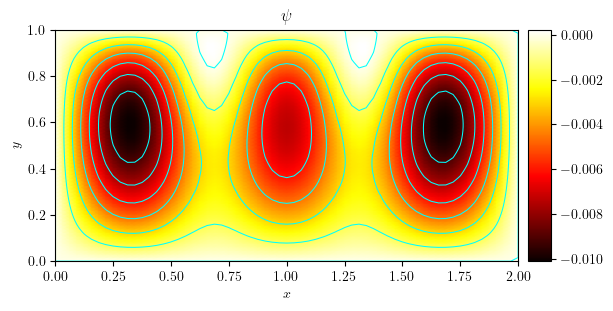

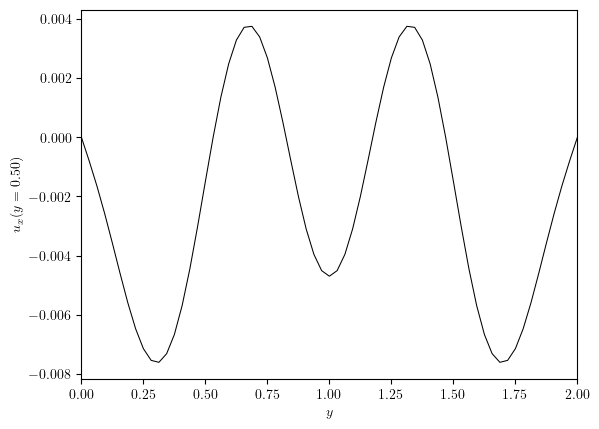

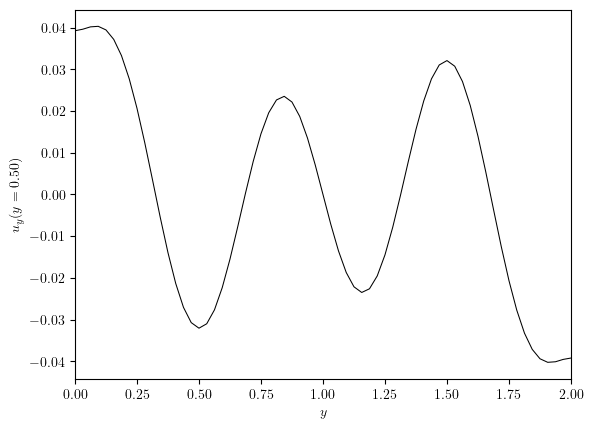

: 

In [ ]:
fig, ax = plot_colormap(psi, title='$\psi$', x_label='$x$', y_label='$y$')
plot_contours(fig, ax, psi, use_cache=True, colors='cyan')
write(fig, f'A07_streamfunction_stokes', './figures', close=False, pickle=False)

ux, uy = fem_function_components(('P', 1), u, names=('ux', 'uy'))

x_axis, ux_x, y_value = cross_section(ux, 'y', 0.5)
plot_line((x_axis, ux_x), x_label='$y$', y_label=f'${u.name}_x(y={y_value:.2f})$')

x_axis, uy_x, y_value = cross_section(uy, 'y', 0.5)
plot_line((x_axis, uy_x), x_label='$y$', y_label=f'${u.name}_y(y={y_value:.2f})$')